# Bayesian Model for Personality Cluster Prediction

This notebook implements multiple Bayesian (Naive Bayes) models for predicting personality clusters based on behavioral and lifestyle indicators.

**Evaluation Metric**: Macro F1 Score (to ensure fairness across all classes)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, CategoricalNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    accuracy_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Data

In [2]:
# Load datasets
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
sample_submission = pd.read_csv('dataset/sample_submission.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"\nSample submission format:")
print(sample_submission.head())

Training data shape: (1913, 14)
Test data shape: (479, 13)

Sample submission format:
   participant_id personality_cluster
0               1           Cluster_B
1               2           Cluster_A
2               3           Cluster_C
3               4           Cluster_A
4               5           Cluster_A


## 3. Exploratory Data Analysis

In [3]:
# Display basic information
print("Training Data Info:")
print(train_df.info())
print("\nFirst few rows:")
train_df.head()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   participant_id             1913 non-null   int64  
 1   age_group                  1913 non-null   int64  
 2   identity_code              1913 non-null   int64  
 3   cultural_background        1913 non-null   int64  
 4   upbringing_influence       1913 non-null   int64  
 5   focus_intensity            1913 non-null   float64
 6   consistency_score          1913 non-null   int64  
 7   external_guidance_usage    1913 non-null   int64  
 8   support_environment_score  1913 non-null   int64  
 9   hobby_engagement_level     1913 non-null   int64  
 10  physical_activity_index    1913 non-null   int64  
 11  creative_expression_index  1913 non-null   int64  
 12  altruism_score             1913 non-null   int64  
 13  personality_cluster        1

,participant_id,age_group,identity_code,cultural_background,upbringing_influence,focus_intensity,consistency_score,external_guidance_usage,support_environment_score,hobby_engagement_level,physical_activity_index,creative_expression_index,altruism_score,personality_cluster
0,643,18,1,0,4,18.118879,24,1,0,1,1,0,0,Cluster_E
1,1753,16,1,3,2,2.469271,19,0,1,0,0,0,1,Cluster_E
2,1402,17,0,2,3,3.456401,25,0,0,0,0,0,0,Cluster_E
3,2033,17,1,0,1,15.838131,25,1,2,0,0,0,0,Cluster_E
4,991,16,0,0,0,1.045373,19,1,2,0,0,1,0,Cluster_E


In [4]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in test data:")
print(test_df.isnull().sum())

Missing values in training data:
participant_id               0
age_group                    0
identity_code                0
cultural_background          0
upbringing_influence         0
focus_intensity              0
consistency_score            0
external_guidance_usage      0
support_environment_score    0
hobby_engagement_level       0
physical_activity_index      0
creative_expression_index    0
altruism_score               0
personality_cluster          0
dtype: int64

Missing values in test data:
participant_id               0
age_group                    0
identity_code                0
cultural_background          0
upbringing_influence         0
focus_intensity              0
consistency_score            0
external_guidance_usage      0
support_environment_score    0
hobby_engagement_level       0
physical_activity_index      0
creative_expression_index    0
altruism_score               0
dtype: int64


In [5]:
# Statistical summary
train_df.describe()

,participant_id,age_group,identity_code,cultural_background,upbringing_influence,focus_intensity,consistency_score,external_guidance_usage,support_environment_score,hobby_engagement_level,physical_activity_index,creative_expression_index,altruism_score
count,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000
mean,1195.642446,16.456351,0.514375,0.872974,1.764245,9.748506,14.618400,0.302143,2.140617,0.380031,0.304757,0.198118,0.156299
std,687.474019,1.124705,0.499924,1.031951,0.988605,5.702764,8.485326,0.459307,1.118309,0.485521,0.460425,0.398686,0.363234
min,1.000000,15.000000,0.000000,0.000000,0.000000,0.008031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,613.000000,15.000000,0.000000,0.000000,1.000000,4.958649,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1189.000000,16.000000,1.000000,0.000000,2.000000,9.518844,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,1787.000000,17.000000,1.000000,2.000000,2.000000,14.407464,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000
max,2392.000000,18.000000,1.000000,3.000000,4.000000,19.968425,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000


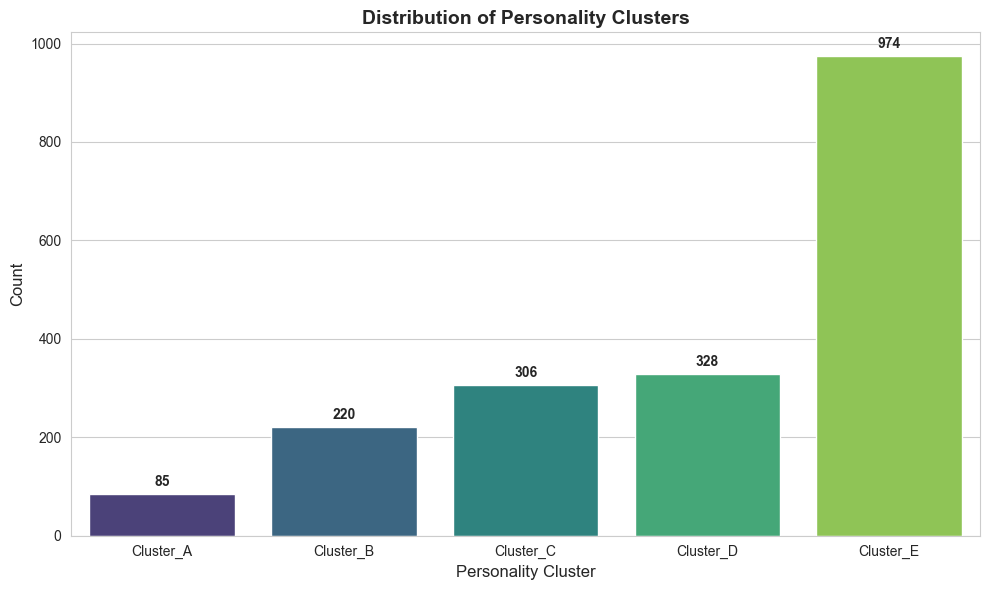


Class Distribution:
personality_cluster
Cluster_A     85
Cluster_B    220
Cluster_C    306
Cluster_D    328
Cluster_E    974
Name: count, dtype: int64

Class Balance Ratio: 0.09


In [6]:
# Class distribution
plt.figure(figsize=(10, 6))
class_counts = train_df['personality_cluster'].value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Personality Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Personality Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

# Add count labels on bars
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClass Distribution:")
print(class_counts)
print(f"\nClass Balance Ratio: {class_counts.min() / class_counts.max():.2f}")

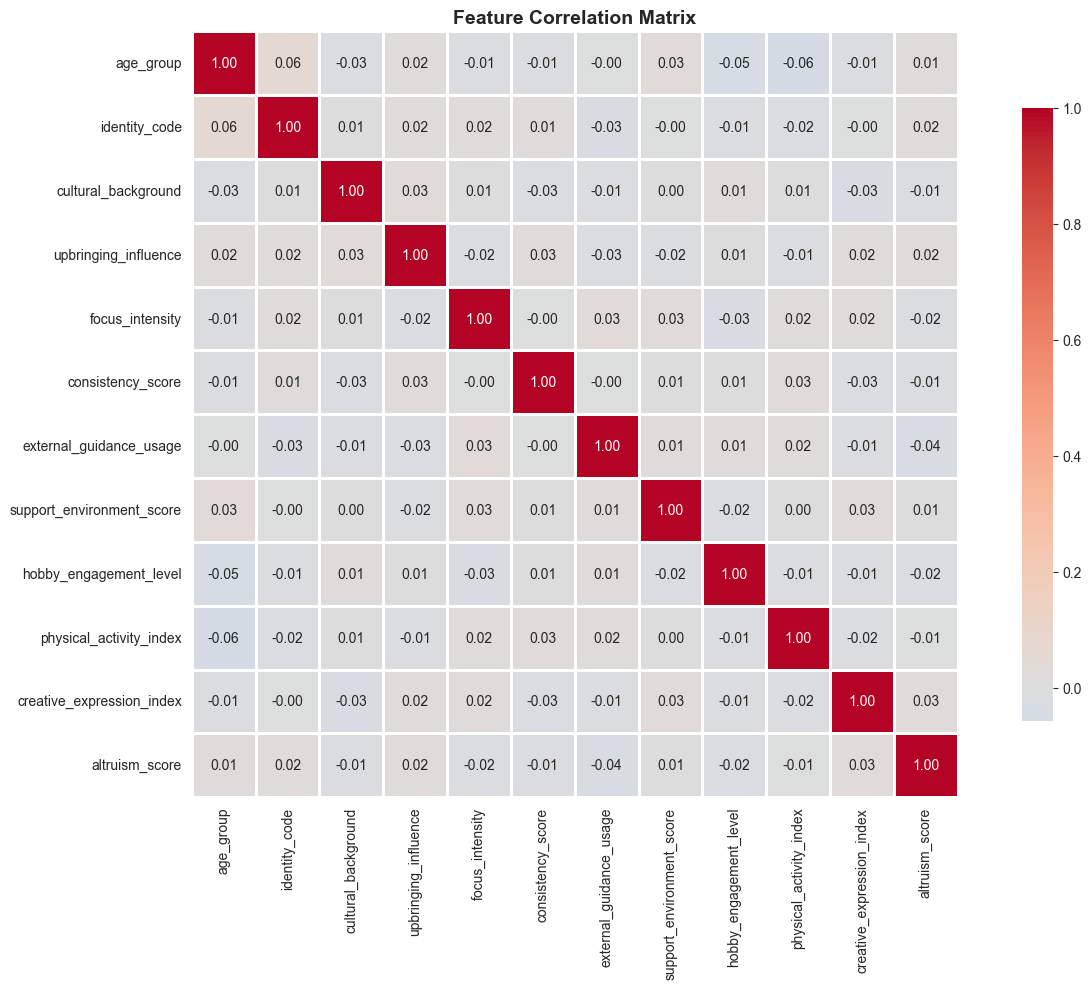

In [7]:
# Feature correlation heatmap
plt.figure(figsize=(14, 10))
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
if 'participant_id' in numeric_cols:
    numeric_cols.remove('participant_id')

correlation_matrix = train_df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [8]:
# Separate features and target
X = train_df.drop(['participant_id', 'personality_cluster'], axis=1)
y = train_df['personality_cluster']
X_test = test_df.drop(['participant_id'], axis=1)
test_ids = test_df['participant_id']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"\nFeatures: {list(X.columns)}")
print(f"\nTarget classes: {sorted(y.unique())}")

Feature matrix shape: (1913, 12)
Target vector shape: (1913,)
Test features shape: (479, 12)

Features: ['age_group', 'identity_code', 'cultural_background', 'upbringing_influence', 'focus_intensity', 'consistency_score', 'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 'physical_activity_index', 'creative_expression_index', 'altruism_score']

Target classes: ['Cluster_A', 'Cluster_B', 'Cluster_C', 'Cluster_D', 'Cluster_E']


In [9]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nValidation set class distribution:")
print(y_val.value_counts().sort_index())

Training set size: 1530
Validation set size: 383

Training set class distribution:
personality_cluster
Cluster_A     68
Cluster_B    176
Cluster_C    245
Cluster_D    262
Cluster_E    779
Name: count, dtype: int64

Validation set class distribution:
personality_cluster
Cluster_A     17
Cluster_B     44
Cluster_C     61
Cluster_D     66
Cluster_E    195
Name: count, dtype: int64


In [10]:
# Feature scaling for Gaussian Naive Bayes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# For Multinomial and Complement NB, we need non-negative features
# Apply Min-Max scaling to ensure all values are positive
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train_positive = min_max_scaler.fit_transform(X_train)
X_val_positive = min_max_scaler.transform(X_val)
X_test_positive = min_max_scaler.transform(X_test)

print("Data preprocessing completed!")
print(f"Scaled features range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")
print(f"Positive features range: [{X_train_positive.min():.2f}, {X_train_positive.max():.2f}]")

Data preprocessing completed!
Scaled features range: [-1.89, 2.32]
Positive features range: [0.00, 1.00]


## 5. Baseline Models

In [11]:
# Initialize baseline models
models = {
    'Gaussian NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'Complement NB': ComplementNB()
}

# Train and evaluate baseline models
baseline_results = {}

for name, model in models.items():
    # Use appropriate data based on model type
    if name == 'Gaussian NB':
        X_tr, X_v = X_train_scaled, X_val_scaled
    else:
        X_tr, X_v = X_train_positive, X_val_positive
    
    # Train model
    model.fit(X_tr, y_train)
    
    # Predictions
    y_pred = model.predict(X_v)
    
    # Calculate metrics
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    accuracy = accuracy_score(y_val, y_pred)
    
    baseline_results[name] = {
        'Macro F1': macro_f1,
        'Accuracy': accuracy,
        'model': model
    }
    
    print(f"\n{'='*60}")
    print(f"{name}")
    print(f"{'='*60}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Display baseline results
baseline_df = pd.DataFrame(baseline_results).T[['Macro F1', 'Accuracy']]
print("\n" + "="*60)
print("BASELINE MODEL COMPARISON")
print("="*60)
print(baseline_df.sort_values('Macro F1', ascending=False))


Gaussian NB
Macro F1 Score: 0.4682
Accuracy: 0.6606

Multinomial NB
Macro F1 Score: 0.1349
Accuracy: 0.5091

Complement NB
Macro F1 Score: 0.3760
Accuracy: 0.5979

BASELINE MODEL COMPARISON
                Macro F1  Accuracy
Gaussian NB     0.468186  0.660574
Complement NB   0.376017  0.597911
Multinomial NB  0.134948  0.509138


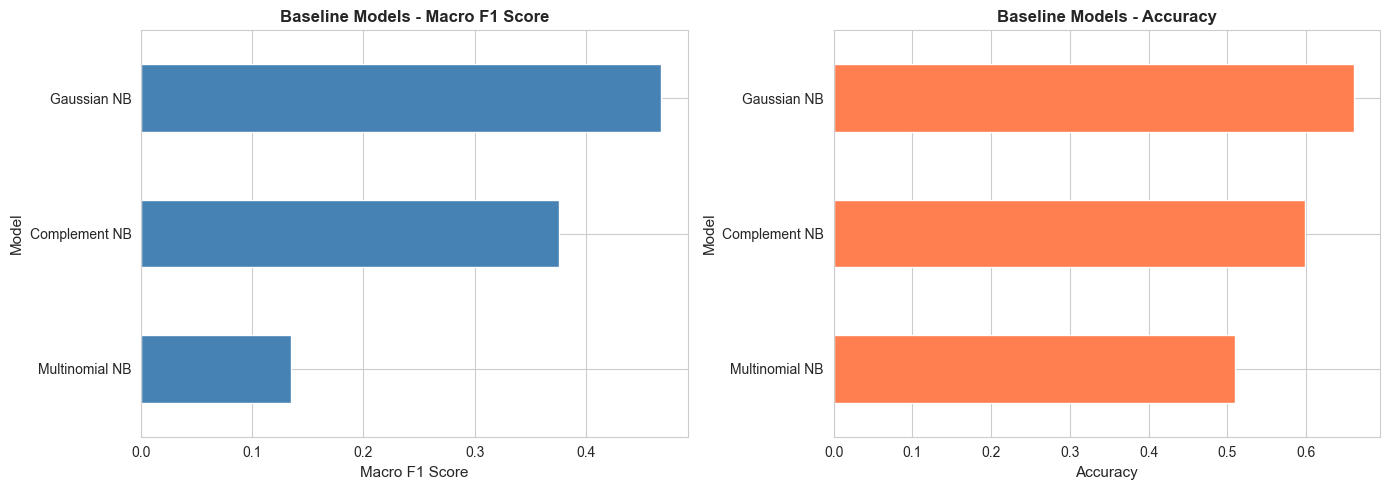

In [12]:
# Visualize baseline results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Macro F1 scores
baseline_df.sort_values('Macro F1', ascending=True).plot(
    kind='barh', y='Macro F1', ax=axes[0], color='steelblue', legend=False
)
axes[0].set_title('Baseline Models - Macro F1 Score', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Macro F1 Score', fontsize=11)
axes[0].set_ylabel('Model', fontsize=11)

# Accuracy scores
baseline_df.sort_values('Accuracy', ascending=True).plot(
    kind='barh', y='Accuracy', ax=axes[1], color='coral', legend=False
)
axes[1].set_title('Baseline Models - Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Accuracy', fontsize=11)
axes[1].set_ylabel('Model', fontsize=11)

plt.tight_layout()
plt.show()

## 6. Hyperparameter Tuning

In [13]:
# Define hyperparameter grids
param_grids = {
    'Gaussian NB': {
        'var_smoothing': np.logspace(-12, -6, 20)
    },
    'Multinomial NB': {
        'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
        'fit_prior': [True, False]
    },
    'Complement NB': {
        'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
        'norm': [True, False]
    }
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Store tuned models
tuned_models = {}
tuning_results = {}

print("Starting hyperparameter tuning...\n")

for name in models.keys():
    print(f"\n{'='*60}")
    print(f"Tuning {name}")
    print(f"{'='*60}")
    
    # Select appropriate data
    if name == 'Gaussian NB':
        X_tr, X_v = X_train_scaled, X_val_scaled
    else:
        X_tr, X_v = X_train_positive, X_val_positive
    
    # Initialize model
    if name == 'Gaussian NB':
        base_model = GaussianNB()
    elif name == 'Multinomial NB':
        base_model = MultinomialNB()
    else:
        base_model = ComplementNB()
    
    # Grid search
    grid_search = GridSearchCV(
        base_model,
        param_grids[name],
        cv=cv,
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_tr, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Evaluate on validation set
    y_pred = best_model.predict(X_v)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    accuracy = accuracy_score(y_val, y_pred)
    
    # Store results
    tuned_models[name] = best_model
    tuning_results[name] = {
        'Best Params': grid_search.best_params_,
        'CV Macro F1': grid_search.best_score_,
        'Val Macro F1': macro_f1,
        'Val Accuracy': accuracy
    }
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV Macro F1: {grid_search.best_score_:.4f}")
    print(f"Validation Macro F1: {macro_f1:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f}")

print("\n" + "="*60)
print("Hyperparameter tuning completed!")
print("="*60)

Starting hyperparameter tuning...


Tuning Gaussian NB
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'var_smoothing': np.float64(1e-12)}
Best CV Macro F1: 0.4629
Validation Macro F1: 0.4682
Validation Accuracy: 0.6606

Tuning Multinomial NB
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'alpha': 0.5, 'fit_prior': False}
Best CV Macro F1: 0.3562
Validation Macro F1: 0.3868
Validation Accuracy: 0.5039

Tuning Complement NB
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'alpha': 10.0, 'norm': True}
Best CV Macro F1: 0.3504
Validation Macro F1: 0.3714
Validation Accuracy: 0.5901

Hyperparameter tuning completed!


In [14]:
# Display tuning results
tuning_df = pd.DataFrame(tuning_results).T[['CV Macro F1', 'Val Macro F1', 'Val Accuracy']]
print("\nTUNED MODEL COMPARISON")
print("="*60)
print(tuning_df.sort_values('Val Macro F1', ascending=False))

# Best parameters
print("\n\nBEST HYPERPARAMETERS")
print("="*60)
for name, results in tuning_results.items():
    print(f"\n{name}:")
    for param, value in results['Best Params'].items():
        print(f"  {param}: {value}")


TUNED MODEL COMPARISON
               CV Macro F1 Val Macro F1 Val Accuracy
Gaussian NB       0.462861     0.468186     0.660574
Multinomial NB    0.356184     0.386756     0.503916
Complement NB     0.350421     0.371376     0.590078


BEST HYPERPARAMETERS

Gaussian NB:
  var_smoothing: 1e-12

Multinomial NB:
  alpha: 0.5
  fit_prior: False

Complement NB:
  alpha: 10.0
  norm: True


## 7. Ensemble Model (Voting Classifier)

In [15]:
# Create ensemble with soft voting
# Note: We'll use the full training data with appropriate scaling for each model

# For ensemble, we need to create a custom approach since different models need different data
# We'll use weighted voting based on validation performance

print("Creating Ensemble Model with Weighted Voting...\n")

# Get predictions from each tuned model
ensemble_predictions = {}
weights = []

for name, model in tuned_models.items():
    if name == 'Gaussian NB':
        X_v = X_val_scaled
        X_t = X_test_scaled
    else:
        X_v = X_val_positive
        X_t = X_test_positive
    
    # Get prediction probabilities
    val_proba = model.predict_proba(X_v)
    test_proba = model.predict_proba(X_t)
    
    ensemble_predictions[name] = {
        'val_proba': val_proba,
        'test_proba': test_proba
    }
    
    # Use validation Macro F1 as weight
    weights.append(tuning_results[name]['Val Macro F1'])

# Normalize weights
weights = np.array(weights)
weights = weights / weights.sum()

print("Model Weights (based on validation Macro F1):")
for name, weight in zip(tuned_models.keys(), weights):
    print(f"  {name}: {weight:.4f}")

# Weighted average of probabilities
val_ensemble_proba = sum(w * pred['val_proba'] for w, pred in zip(weights, ensemble_predictions.values()))
test_ensemble_proba = sum(w * pred['test_proba'] for w, pred in zip(weights, ensemble_predictions.values()))

# Get class labels
classes = tuned_models['Gaussian NB'].classes_

# Make predictions
val_ensemble_pred = classes[np.argmax(val_ensemble_proba, axis=1)]
test_ensemble_pred = classes[np.argmax(test_ensemble_proba, axis=1)]

# Evaluate ensemble on validation set
ensemble_macro_f1 = f1_score(y_val, val_ensemble_pred, average='macro')
ensemble_accuracy = accuracy_score(y_val, val_ensemble_pred)

print(f"\nEnsemble Validation Results:")
print(f"  Macro F1 Score: {ensemble_macro_f1:.4f}")
print(f"  Accuracy: {ensemble_accuracy:.4f}")

Creating Ensemble Model with Weighted Voting...

Model Weights (based on validation Macro F1):
  Gaussian NB: 0.3818
  Multinomial NB: 0.3154
  Complement NB: 0.3028

Ensemble Validation Results:
  Macro F1 Score: 0.4669
  Accuracy: 0.6606


## 8. Model Evaluation

In [16]:
# Select best model (compare individual models with ensemble)
all_results = tuning_results.copy()
all_results['Ensemble'] = {
    'Best Params': 'Weighted Voting',
    'CV Macro F1': None,
    'Val Macro F1': ensemble_macro_f1,
    'Val Accuracy': ensemble_accuracy
}

results_df = pd.DataFrame(all_results).T[['Val Macro F1', 'Val Accuracy']]
print("\nFINAL MODEL COMPARISON")
print("="*60)
print(results_df.sort_values('Val Macro F1', ascending=False))

# Select best model
best_model_name = results_df['Val Macro F1'].idxmax()
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Macro F1 Score: {results_df.loc[best_model_name, 'Val Macro F1']:.4f}")


FINAL MODEL COMPARISON
               Val Macro F1 Val Accuracy
Gaussian NB        0.468186     0.660574
Ensemble           0.466855     0.660574
Multinomial NB     0.386756     0.503916
Complement NB      0.371376     0.590078

🏆 Best Model: Gaussian NB
   Macro F1 Score: 0.4682


In [17]:
# Detailed evaluation of best model
if best_model_name == 'Ensemble':
    y_val_pred = val_ensemble_pred
    y_test_pred = test_ensemble_pred
else:
    best_model = tuned_models[best_model_name]
    if best_model_name == 'Gaussian NB':
        y_val_pred = best_model.predict(X_val_scaled)
        y_test_pred = best_model.predict(X_test_scaled)
    else:
        y_val_pred = best_model.predict(X_val_positive)
        y_test_pred = best_model.predict(X_test_positive)

print(f"\nDETAILED EVALUATION: {best_model_name}")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, digits=4))


DETAILED EVALUATION: Gaussian NB

Classification Report:
              precision    recall  f1-score   support

   Cluster_A     0.5000    0.1176    0.1905        17
   Cluster_B     0.4412    0.3409    0.3846        44
   Cluster_C     0.4250    0.5574    0.4823        61
   Cluster_D     0.4898    0.3636    0.4174        66
   Cluster_E     0.8241    0.9128    0.8662       195

    accuracy                         0.6606       383
   macro avg     0.5360    0.4585    0.4682       383
weighted avg     0.6445    0.6606    0.6424       383



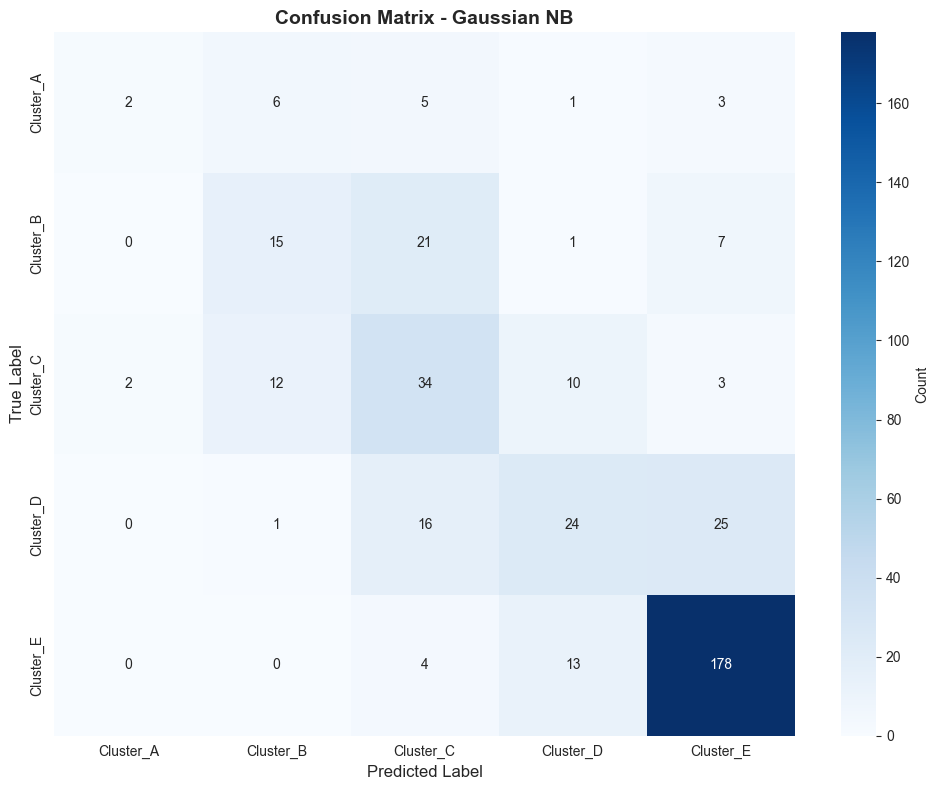

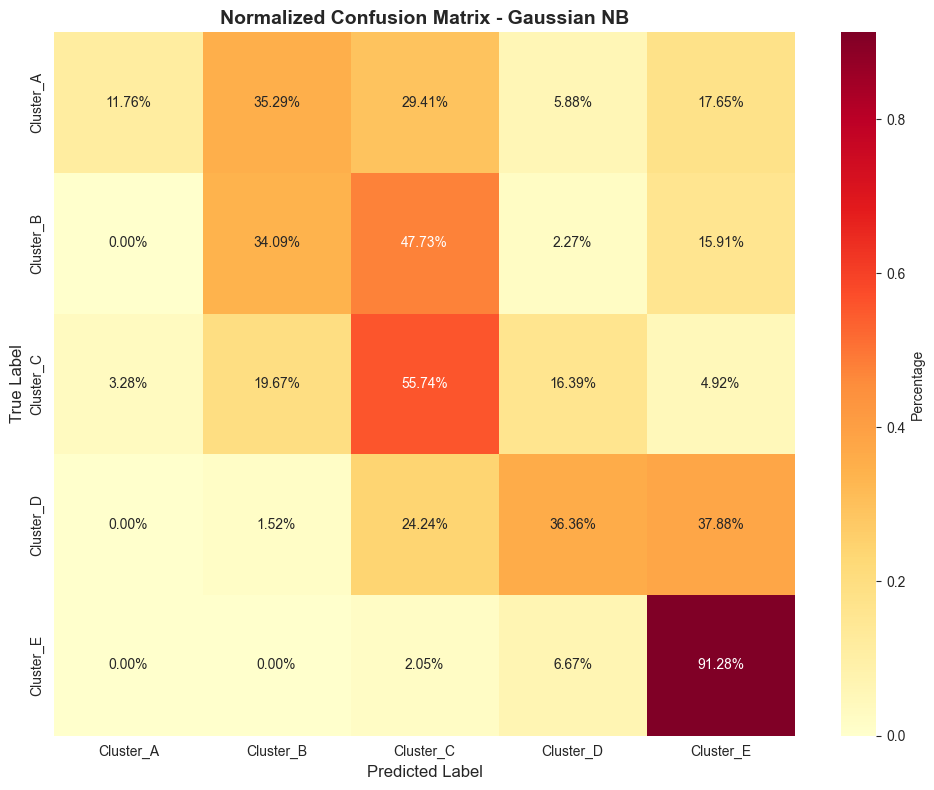

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y.unique()), 
            yticklabels=sorted(y.unique()),
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()),
            cbar_kws={'label': 'Percentage'})
plt.title(f'Normalized Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

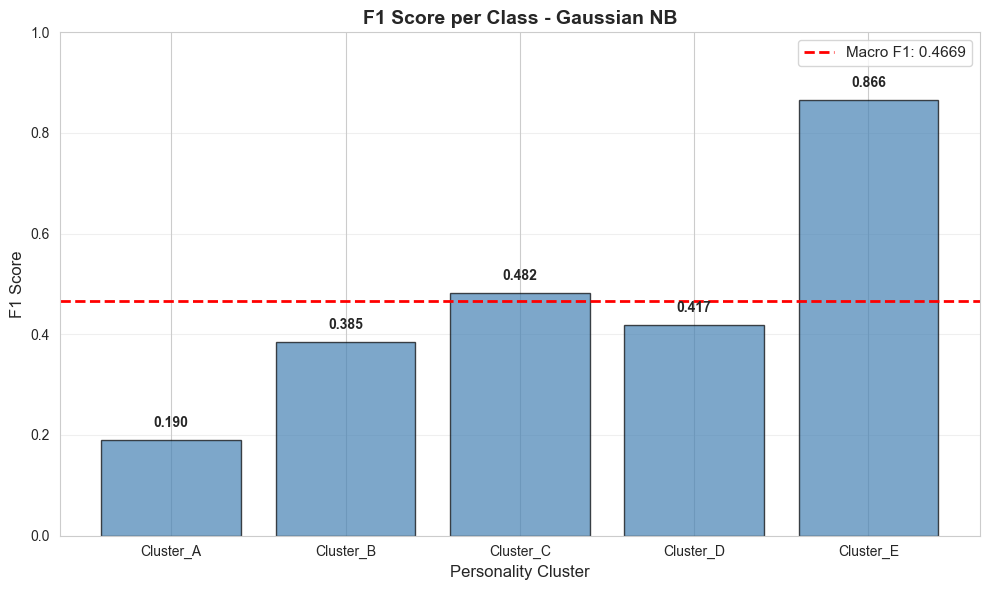

In [19]:
# Per-class F1 scores visualization
from sklearn.metrics import f1_score

classes_sorted = sorted(y.unique())
f1_per_class = [f1_score(y_val, y_val_pred, labels=[c], average='macro') for c in classes_sorted]

plt.figure(figsize=(10, 6))
bars = plt.bar(classes_sorted, f1_per_class, color='steelblue', alpha=0.7, edgecolor='black')
plt.axhline(y=ensemble_macro_f1, color='red', linestyle='--', linewidth=2, label=f'Macro F1: {ensemble_macro_f1:.4f}')
plt.title(f'F1 Score per Class - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Personality Cluster', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, f1_per_class):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


5-Fold Cross-Validation Scores for Gaussian NB:
  Scores: [0.43271891 0.48207888 0.49509708 0.43034137 0.44156907]
  Mean: 0.4564 (+/- 0.0538)


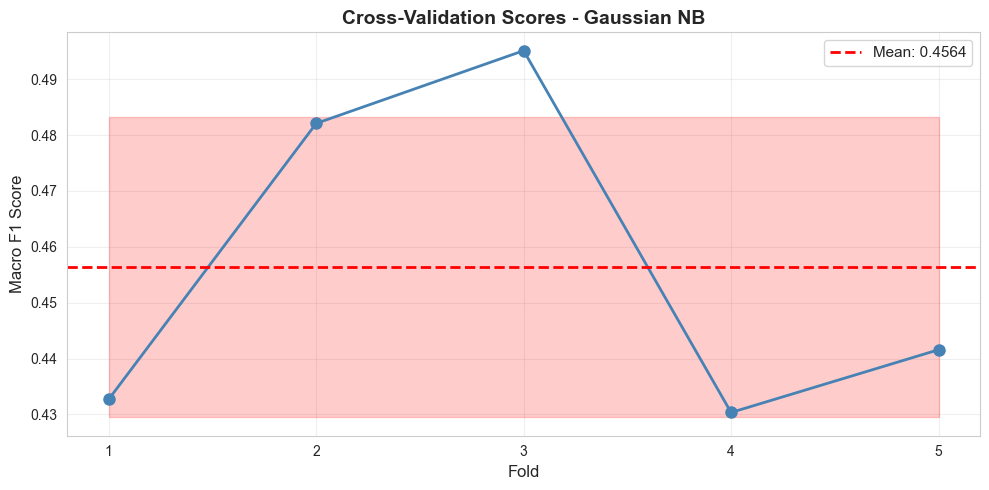

In [20]:
# Cross-validation scores for best individual model (if not ensemble)
if best_model_name != 'Ensemble':
    best_individual_model = tuned_models[best_model_name]
    
    if best_model_name == 'Gaussian NB':
        X_cv = X_train_scaled
    else:
        X_cv = X_train_positive
    
    cv_scores = cross_val_score(best_individual_model, X_cv, y_train, 
                                 cv=5, scoring='f1_macro', n_jobs=-1)
    
    print(f"\n5-Fold Cross-Validation Scores for {best_model_name}:")
    print(f"  Scores: {cv_scores}")
    print(f"  Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Visualize CV scores
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8, color='steelblue')
    plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.4f}')
    plt.fill_between(range(1, 6), cv_scores.mean() - cv_scores.std(), 
                     cv_scores.mean() + cv_scores.std(), alpha=0.2, color='red')
    plt.title(f'Cross-Validation Scores - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Macro F1 Score', fontsize=12)
    plt.xticks(range(1, 6))
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 9. Generate Submission File

In [21]:
# Create submission dataframe
submission = pd.DataFrame({
    'participant_id': test_ids,
    'personality_cluster': y_test_pred
})

# Save submission file
submission.to_csv('submission_bayesian.csv', index=False)

print("Submission file created: submission_bayesian.csv")
print(f"\nSubmission shape: {submission.shape}")
print(f"\nFirst few predictions:")
print(submission.head(10))

# Verify submission format
print("\n" + "="*60)
print("SUBMISSION VALIDATION")
print("="*60)
print(f"✓ Number of predictions: {len(submission)}")
print(f"✓ Columns: {list(submission.columns)}")
print(f"✓ Unique clusters in predictions: {sorted(submission['personality_cluster'].unique())}")
print(f"✓ Missing values: {submission.isnull().sum().sum()}")

# Prediction distribution
print(f"\nPrediction Distribution:")
print(submission['personality_cluster'].value_counts().sort_index())

Submission file created: submission_bayesian.csv

Submission shape: (479, 2)

First few predictions:
   participant_id personality_cluster
0            1005           Cluster_E
1             197           Cluster_C
2            2343           Cluster_E
3            1709           Cluster_B
4             436           Cluster_E
5             322           Cluster_D
6            1473           Cluster_E
7            1704           Cluster_D
8             901           Cluster_D
9            1058           Cluster_E

SUBMISSION VALIDATION
✓ Number of predictions: 479
✓ Columns: ['participant_id', 'personality_cluster']
✓ Unique clusters in predictions: ['Cluster_A', 'Cluster_B', 'Cluster_C', 'Cluster_D', 'Cluster_E']
✓ Missing values: 0

Prediction Distribution:
personality_cluster
Cluster_A      3
Cluster_B     37
Cluster_C    114
Cluster_D     61
Cluster_E    264
Name: count, dtype: int64


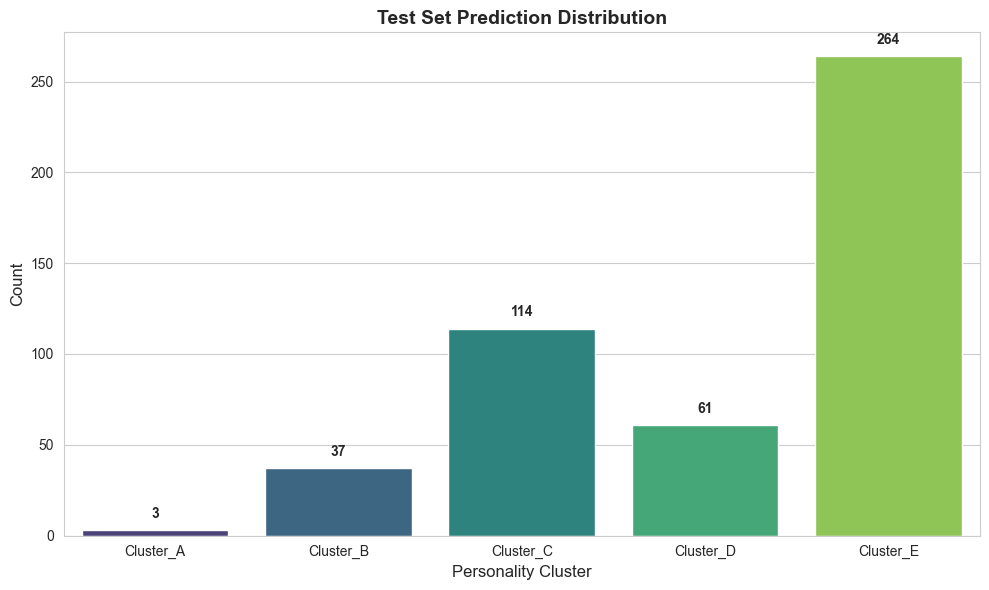

In [22]:
# Visualize prediction distribution
plt.figure(figsize=(10, 6))
pred_counts = submission['personality_cluster'].value_counts().sort_index()
sns.barplot(x=pred_counts.index, y=pred_counts.values, palette='viridis')
plt.title('Test Set Prediction Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Personality Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels
for i, v in enumerate(pred_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Summary

In [23]:
print("\n" + "="*60)
print("BAYESIAN MODEL SUMMARY")
print("="*60)
print(f"\n📊 Dataset:")
print(f"   Training samples: {len(train_df)}")
print(f"   Test samples: {len(test_df)}")
print(f"   Features: {X.shape[1]}")
print(f"   Classes: {len(y.unique())}")

print(f"\n🤖 Models Evaluated:")
for name in models.keys():
    print(f"   - {name}")
print(f"   - Ensemble (Weighted Voting)")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Validation Macro F1: {results_df.loc[best_model_name, 'Val Macro F1']:.4f}")
print(f"   Validation Accuracy: {results_df.loc[best_model_name, 'Val Accuracy']:.4f}")

if best_model_name != 'Ensemble':
    print(f"\n⚙️  Best Hyperparameters:")
    for param, value in tuning_results[best_model_name]['Best Params'].items():
        print(f"   {param}: {value}")

print(f"\n📁 Output:")
print(f"   Submission file: submission_bayesian.csv")
print(f"   Predictions: {len(submission)}")

print("\n" + "="*60)
print("✅ Analysis Complete!")
print("="*60)


BAYESIAN MODEL SUMMARY

📊 Dataset:
   Training samples: 1913
   Test samples: 479
   Features: 12
   Classes: 5

🤖 Models Evaluated:
   - Gaussian NB
   - Multinomial NB
   - Complement NB
   - Ensemble (Weighted Voting)

🏆 Best Model: Gaussian NB
   Validation Macro F1: 0.4682
   Validation Accuracy: 0.6606

⚙️  Best Hyperparameters:
   var_smoothing: 1e-12

📁 Output:
   Submission file: submission_bayesian.csv
   Predictions: 479

✅ Analysis Complete!
